<a href="https://colab.research.google.com/github/shenyuchun/flutter-gcp-aws/blob/main/homework2_csce670_spring2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### CSCE 670 :: Information Storage & Retrieval :: Texas A&M University :: Spring 2025


# Homework 2:  Ranking with text and links

### 100 points [4% of your final grade]

### Due: February 24 (Monday) by 11:59pm

*Goals of this homework:* In this homework you will focus on the (i) basics of parsing data and graph building; and (ii) basics of PageRank and HITS.

*Submission instructions (Canvas):* To submit your homework, rename this notebook as `UIN_hw2.ipynb`. For example, my homework submission would be something like `555001234_hw2.ipynb`. Submit this notebook via Canvas (look for the homework 2 assignment there). Your notebook should be completely self-contained, with the results visible in the notebook. We should not have to run any code from the command line, nor should we have to run your code within the notebook (though we reserve the right to do so). So please run all the cells for us, and then submit.

*Late submission policy:* For this homework, you may use as many late days as you like (up to the 5 total allotted to you).

*Collaboration policy:* You are expected to complete each homework independently. Your solution should be written by you without the direct aid or help of anyone else. However, we believe that collaboration and team work are important for facilitating learning, so we encourage you to discuss problems and general problem approaches (but not actual solutions) with your classmates. You may post on Canvas, search StackOverflow, even use ChatGPT. But if you do get help in this way, you must inform us by **filling out the Collaboration Declarations at the bottom of this notebook**. See the course syllabus for details.

*Example: I found helpful code on stackoverflow at https://stackoverflow.com/questions/11764539/writing-fizzbuzz that helped me solve Problem 2.*

The basic rule is that no student should explicitly share a solution with another student (and thereby circumvent the basic learning process), but it is okay to share general approaches, directions, and so on. If you feel like you have an issue that needs clarification, feel free to contact either me or the TA.

# Dataset: Enron Email Dataset

We are providing you with a collection of emails from the Enron Email Dataset. The Enron Email Dataset was collected and prepared by the CALO Project (A Cognitive Assistant that Learns and Organizes). It contains data from about 150 users, mostly senior management of Enron. The full corpus contains a total of about 0.5M messages (https://www.cs.cmu.edu/~enron/).

For this homework, we will use a subset of the dataset. The subset contains the `sent emails` from 78 users in the dataset. We have zipped the dataset and provided it to you on Canvas as `enron_sent_mail.zip`. The zip file is about 45 MB. Each folder contains a subfolder named `_sent_mail` which contains the sent emails of that user. Each email is stored in a separate file, containing the relationship of `who send to whom` as noted by `From:` and `To:` entries. We are going to build a graph using the relationships between the users!


Below is an example of one email.

```text
Message-ID: <33025919.1075857594206.JavaMail.evans@thyme>
Date: Wed, 13 Dec 2000 13:09:00 -0800 (PST)
From: john.arnold@enron.com
To: slafontaine@globalp.com
Subject: re:spreads
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: John Arnold
X-To: slafontaine@globalp.com @ ENRON
X-cc:
X-bcc:
X-Folder: \John_Arnold_Dec2000\Notes Folders\'sent mail
X-Origin: Arnold-J
X-FileName: Jarnold.nsf

saw a lot of the bulls sell summer against length in front to mitigate
margins/absolute position limits/var.  as these guys are taking off the
front, they are also buying back summer.  el paso large buyer of next winter
today taking off spreads.  certainly a reason why the spreads were so strong
on the way up and such a piece now.   really the only one left with any risk
premium built in is h/j now.   it was trading equivalent of 180 on access,
down 40+ from this morning.  certainly if we are entering a period of bearish
to neutral trade, h/j will get whacked.  certainly understand the arguments
for h/j.  if h settles $20, that spread is probably worth $10.  H 20 call was
trading for 55 on monday.  today it was 10/17.  the market's view of
probability of h going crazy has certainly changed in past 48 hours and that
has to be reflected in h/j.




slafontaine@globalp.com on 12/13/2000 04:15:51 PM
To: slafontaine@globalp.com
cc: John.Arnold@enron.com
Subject: re:spreads



mkt getting a little more bearish the back of winter i think-if we get another
cold blast jan/feb mite move out. with oil moving down and march closer flat
px
wide to jan im not so bearish these sprds now-less bullish march april as
well.
```

# Part 1: Parse the Email Data to Build a Graph (50 points)

---

Recall how we parse the email content in HW1. Now, in this part, we're going to parse the dataset to build a graph. So, instead of viewing the world as web pages with hyperlinks (where pages = nodes, hyperlinks = edges), we view it as users in an email network. Over this graph, we can apply classic methods like PageRank and Hubs-and-Authorities to order the users according to some notion of importance.

For the first part, you will complete the following code to construct the graph based on the given data. In this graph, the node is the user and a link between two users is added if user A sent an email to user B. The weight of the link is the number of emails sent between user A and user B.

You will need to write a python code to loop through each email file and extract the sender and receiver of each email.
Specifically, you should extract the sender from the `From: john.arnold@enron.com` and receiver from the `To: slafontaine@globalp.com` fields at the top of each email.

* Use the email address to represent a unique user.
* Remove any space in the email. User lower case for the email address.
* Only extract the email addresses that are in the `From:` and `To:` fields at the top of the email. If the email contains forwarded emails below, you can ignore them.
* Choose a proper data structure to store the unique users and the number of times they appear in the dataset. We will use it to build a graph later.

### Print the number of total emails (5 points)

In [5]:
import os
import re
import networkx as nx
from collections import defaultdict
import os
import zipfile

# 設定 Colab 上的上傳目錄
zip_path = "/content/enron_sent_mail.zip"
extract_path = "/content/enron_sent_mail/enron_sent_mail"


# 解析 email 檔案的函數
def parse_email(file_path):
    """解析郵件文件，提取發件人 (From) 和收件人 (To)"""
    from_email = None
    to_emails = []

    with open(file_path, "r", encoding="latin1") as file:
        for line in file:
            # 找到 From: 字段
            if line.lower().startswith("from:"):
                from_email = line.split(":", 1)[1].strip().lower()

            # 找到 To: 字段
            elif line.lower().startswith("to:"):
                to_emails = [email.strip().lower() for email in line.split(":", 1)[1].split(",")]

            # 只讀取郵件的標頭部分，遇到空行後停止解析
            elif line.strip() == "":
                break

    return from_email, to_emails

# 建立 Email 網絡的函數
def build_email_graph(base_dir):
    """遍歷 Enron 郵件數據，構建發送關係圖"""
    email_graph = defaultdict(lambda: defaultdict(int))  # 雙層字典存儲 {發件人: {收件人: 次數}}
    total_emails = 0  # 記錄郵件數量

    # 遍歷每個用戶的發送郵件文件夾
    for user_folder in os.listdir(base_dir):
        sent_mail_dir = os.path.join(base_dir, user_folder, "_sent_mail")

        if os.path.isdir(sent_mail_dir):
            for email_file in os.listdir(sent_mail_dir):
                file_path = os.path.join(sent_mail_dir, email_file)

                # 解析郵件
                from_email, to_emails = parse_email(file_path)

                # 構建發送關係
                if from_email and to_emails:
                    total_emails += 1  # 計算有效郵件數量
                    for to_email in to_emails:
                        email_graph[from_email][to_email] += 1

    return email_graph, total_emails

# 設定資料夾路徑（請修改為你的解壓縮路徑）
base_directory = "/content/enron_sent_mail/enron_sent_mail"

# 解析郵件並構建 Email Graph
email_graph, total_emails = build_email_graph(base_directory)

# 轉換為 NetworkX 圖
G = nx.DiGraph()
for sender, receivers in email_graph.items():
    for receiver, count in receivers.items():
        G.add_edge(sender, receiver, weight=count)

# 儲存圖結構
nx.write_gml(G, "email_network.gml")  # 儲存為 GML 格式以供後續分析

# ✅ Print the total number of emails processed
print(f"Total number of emails processed: {total_emails}")
print(f"Email 網絡圖構建完成，共有 {G.number_of_nodes()} 個節點，{G.number_of_edges()} 條邊。")


Total number of emails processed: 30034
Email 網絡圖構建完成，共有 5056 個節點，7980 條邊。


### Print the number of unique users (5 points)

In [6]:
# your code here
# ✅ 計算唯一用戶數量（節點數）
unique_users = G.number_of_nodes()
print(f"👥 Number of unique users: {unique_users}")


👥 Number of unique users: 5056


### Print the top-5 users ranked by the number of emails they involved in the dataset (5 points)

For example, email 1 we have user A sent to user B, email 2 we have user C sent to user A. Then, user A is involved in 2 emails, user B and C are involved in 1 email. So, the top users are A, B, C.

Your output should look like this:

```text
user emails_involved
john.arnold@enron.com 100
slafontaine@globalp.com 98
......
```

In [15]:
# your code here
# ✅ 計算每個用戶的參與次數（發件人 + 收件人）
user_email_count = defaultdict(int)

for sender, receivers in email_graph.items():
    user_email_count[sender] += sum(receivers.values())  # 發件人發出的郵件數
    for receiver, count in receivers.items():
        user_email_count[receiver] += count  # 收件人收到的郵件數

# ✅ 取得參與郵件最多的前 5 名
top_5_users = sorted(user_email_count.items(), key=lambda x: x[1], reverse=True)[:5]

# ✅ 打印結果
print("\n👑 Top-5 users ranked by emails involved:")
print("User\tEmails Involved")
for user, count in top_5_users:
    print(f"{user}\t{count}")



👑 Top-5 users ranked by emails involved:
User	Emails Involved
kay.mann@enron.com	5230
vince.kaminski@enron.com	3682
chris.germany@enron.com	2926
eric.bass@enron.com	1976
	1693


### Print the top-5 users who sent out the most emails in the dataset (5 points)

Note that here, we only consider the person who sent the email, not the receiver.

Your output should look like this:

```text
user emails_sent
john.arnold@enron.com 100
slafontaine@globalp.com 98
......
```

In [16]:
# your code here
# ✅ 計算每個發件人發送的郵件數量
user_sent_count = {sender: sum(receivers.values()) for sender, receivers in email_graph.items()}

# ✅ 取得發送郵件最多的前 5 名
top_5_senders = sorted(user_sent_count.items(), key=lambda x: x[1], reverse=True)[:5]

# ✅ 打印結果
print("\n📤 Top-5 users who sent the most emails:")
print("User\tEmails Sent")
for user, count in top_5_senders:
    print(f"{user}\t{count}")



📤 Top-5 users who sent the most emails:
User	Emails Sent
kay.mann@enron.com	5219
vince.kaminski@enron.com	3646
chris.germany@enron.com	2894
eric.bass@enron.com	1950
kate.symes@enron.com	1539


### Print the top-5 users who received the most emails in the dataset (5 points)

Note that here, we only consider the receiver, not sender.

Your output should look like this:

```text
user emails_received
john.arnold@enron.com 100
slafontaine@globalp.com 98
......
```

In [17]:
# your code here
# ✅ 計算每個收件人收到的郵件數量
user_received_count = defaultdict(int)

for sender, receivers in email_graph.items():
    for receiver, count in receivers.items():
        user_received_count[receiver] += count  # 記錄收件人收到的郵件數

# ✅ 取得收到郵件最多的前 5 名
top_5_receivers = sorted(user_received_count.items(), key=lambda x: x[1], reverse=True)[:5]

# ✅ 打印結果
print("\n📥 Top-5 users who received the most emails:")
print("User\tEmails Received")
for user, count in top_5_receivers:
    print(f"{user}\t{count}")



📥 Top-5 users who received the most emails:
User	Emails Received
	1693
vkaminski@aol.com	1061
suzanne.adams@enron.com	427
shirley.crenshaw@enron.com	301
nmann@erac.com	285


### Let's build the graph! (15 points)

Here we are going to use the `networkx` library to build the graph. You can install the library by running `!pip install networkx`.

We are going to build an `undirected` graph (regardless of who sent to whom). The nodes of the graph are the users (represented by the unique email address) and the edges are the emails sent between the users. The weight of the edge is the number of emails sent between the users.

For example, if user A sent 3 emails to user B, and user B sent 2 emails to user A, then the weight of the edge between A and B is 3+2=5.

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

In [ ]:
# ✅ 記錄無向邊的權重
email_edges = defaultdict(int)

# ✅ 遍歷郵件數據並收集發送關係
for sender, receivers in email_graph.items():
    for receiver, count in receivers.items():
        # 由於是無向圖，所以排序 (A, B) 和 (B, A) 視為同一條邊
        edge = tuple(sorted([sender, receiver]))
        email_edges[edge] += count

In [19]:
import os
import networkx as nx
from collections import defaultdict
from tqdm import tqdm  # 用於顯示進度條

# ✅ 記錄唯一用戶（節點）和無向邊（發送關係）
unique_users = set()
email_edges = defaultdict(int)

# ✅ 遍歷郵件數據，解析發件人和收件人
for sender, receivers in tqdm(email_graph.items(), desc="Processing emails"):
    unique_users.add(sender)  # 加入發件人
    for receiver, count in receivers.items():
        unique_users.add(receiver)  # 加入收件人
        edge = tuple(sorted([sender, receiver]))  # 確保無向邊 (A, B) = (B, A)
        email_edges[edge] += count  # 累計郵件數量作為權重

# ✅ 建立無向圖
G = nx.Graph()

# ✅ 加入節點（用戶）
G.add_nodes_from(unique_users)

# ✅ 加入邊（發送關係）及其權重
for (user_A, user_B), weight in tqdm(email_edges.items(), desc="Processing edges"):
    G.add_edge(user_A, user_B, weight=weight)

# ✅ 打印結果
print(f"\n📂 無向圖構建完成，共有 {G.number_of_nodes()} 個節點，{G.number_of_edges()} 條邊。")


Processing edges: 100%|██████████| 7874/7874 [00:00<00:00, 524096.64it/s]


📂 無向圖構建完成，共有 5056 個節點，7874 條邊。


### Visualization of the graph (5 points)

Now you have built the graph. Let's visualize the graph. Use any package you like to visualize the graph.

You can find some examples here: https://networkx.org/documentation/stable/auto_examples/index.html

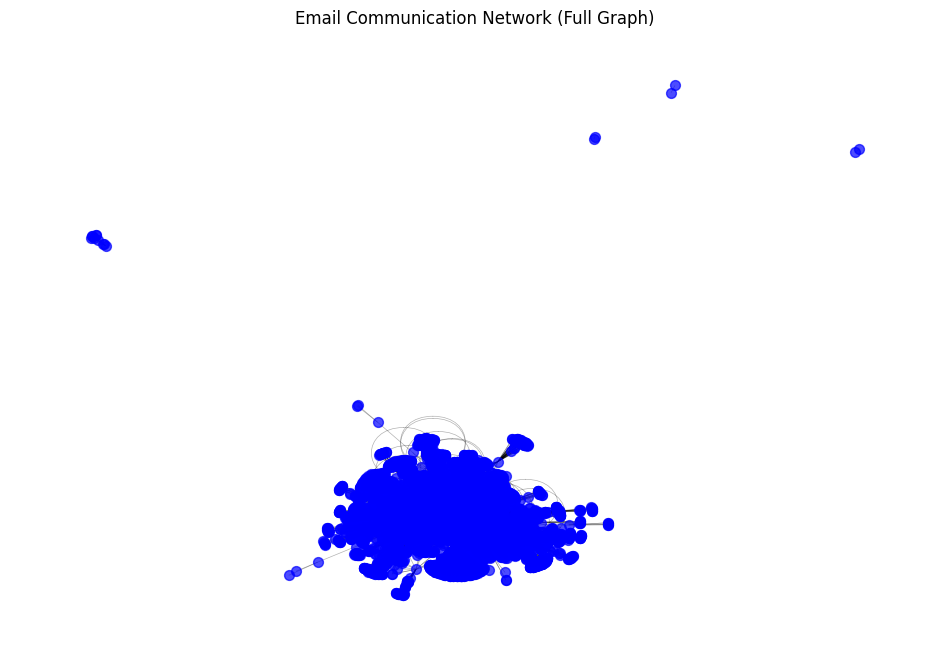

In [20]:
# your code here
!pip install matplotlib networkx
import matplotlib.pyplot as plt
import networkx as nx

# ✅ 使用 spring_layout 計算節點位置（適合無向圖）
plt.figure(figsize=(12, 8))  # 設定圖片大小
pos = nx.spring_layout(G, seed=42)  # 讓圖的佈局每次都一樣

# ✅ 畫出節點與邊
nx.draw_networkx_nodes(G, pos, node_size=50, alpha=0.7, node_color="blue")
nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5)

# ✅ 顯示圖
plt.title("Email Communication Network (Full Graph)")
plt.axis("off")  # 移除座標軸
plt.show()


### Observation of the graph (5 points)

What can you observe from the graph? Is there any user who is the center of the graph? Is there any user who is isolated from the graph? Which node has the most edges? Please provide your observations in bullet points based on the visualization.

Your output should look like this:

```text
* Observation 1:
* Observation 2:
* Observation 3:
```

*your discussion here*

# Part 2: Link-based Ranking (50 points)

---

In this part, over the graph you built, we're going to adapt the classic PageRank and  Hubs-and-Authorities approaches to allow us to find the most important users. So, instead of viewing the world as web pages with hyperlinks (where pages = nodes, hyperlinks = edges), we view it as users in an email network.


### A: PageRank (10 points)
Given this graph, your first job is to simply run PageRank to find the highest ranking users. You may use the [built-in pagerank](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html) function in networkx.

Print the top-5 highest PageRank scores in `user: score` format.

In [ ]:
# your code here

### B: Personalized PageRank (10 points)
In class, we focused on the traditional "vanilla" PageRank where the teleportation factor is uniform -- that is, the random surfer occasionally is bored and will teleport randomly to a node in the graph. Instead, we can bias the teleportation to a subset of nodes in the graph. This is called Personalized PageRank! The idea is that the PageRank scores will be biased towards nodes near the ones that you teleport to.

For this problem assume the user of interest is `"john.arnold@enron.com"`. You should compute the personalized PageRank and print the top-5 highest personalized PageRank scores in `user: score` format. Note that there is a nice function parameter called "personalization" in the built-in pagerank that you can use for this problem.

In [ ]:
# your code here

### C: Hubs and Authorities (20 points)
Just like we can calculate PageRank over the user graph, we can also find the hub and authority scores for users.

For this part, you should return the top-5 users with highest Hub scores and the top-5 users with the highest Authority scores. The **output** should be like:

`Hub Scores`

`1. user1: score1`

`...`

`Authority Scores`

`1. user1: score1`

` ...`




In [ ]:
# Your code here

### Discussion (10 points)
Briefly discuss the differences you see between the three methods. You should play with the personalization parameters in PageRank and show some findings.


*your discussion here*

# Collaboration Declarations

*You should fill out your collaboration declarations here.*
